## Librerías Utilizadas

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Iteraciones de modelo

In [2]:
arabica = pd.read_csv('../data/processed/arabica_processed.csv')
arabica

,Country.of.Origin,Variety,Processing.Method,Moisture,Harvest.Year,Color,altitude_mean_meters,Category.One.Defects,Category.Two.Defects,Calidad
0,5,7,4,0.12,2014,1,2075.0,0,1,2
1,5,7,4,0.12,2014,1,2075.0,0,2,2
2,5,7,0,0.10,2014,1,1822.5,0,4,2
3,1,1,4,0.10,2015,1,1450.0,0,0,2
4,14,7,4,0.00,2014,1,2019.0,0,0,2
...,...,...,...,...,...,...,...,...,...,...
3080,18,11,4,0.12,2013,1,1950.0,0,1,2
3081,9,13,4,0.00,2012,1,1200.0,0,6,2
3082,11,7,4,0.13,2012,1,1320.0,0,0,2
3083,18,11,4,0.12,2013,1,1600.0,0,1,2


In [3]:
X = arabica.drop(columns='Calidad')
y = arabica.Calidad

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, shuffle=True, random_state=5)

print(Xtrain.shape)
print(Xtest.shape)
print(ytrain.shape)
print(ytest.shape)

(2313, 9)
(772, 9)
(2313,)
(772,)


In [4]:
pipe = Pipeline(steps=[("scaler", StandardScaler()),
                       ("selectkbest", SelectKBest()),
                       ("pca", PCA()),
                       ('classifier', RandomForestClassifier())])

logistic_params = {'selectkbest__k' : [9],
                   'pca__n_components': [8,9,10],
                   'classifier': [LogisticRegression(solver='liblinear')],
                   'classifier__penalty': ['l1','l2']}

rf_params = {'scaler' : [StandardScaler(), None],
             'selectkbest__k' : [9],
             'pca__n_components': [8,9,10],
             'classifier': [RandomForestClassifier()],
             'classifier__max_features': [2,3,4],
             'classifier__max_depth': [3,5,7]}

gb_params = {'scaler' : [StandardScaler(), None],
             'selectkbest__k' : [9],
             'pca__n_components': [8,9,10],
             'classifier': [GradientBoostingClassifier()],
             'classifier__max_features': [2,3,4],
             'classifier__max_depth': [7]}

knn_params = {'selectkbest__k' : [9],
              'pca__n_components': [8,9,10],
              'classifier': [KNeighborsClassifier()],
              'classifier__n_neighbors': [5,7,12]}

svm_params = {'selectkbest__k' : [9],
              'pca__n_components': [8,9,10],
              'classifier': [SVC()],
              'classifier__C': [0.1, 1, 10]}

search_space = [logistic_params, rf_params, gb_params, knn_params, svm_params]

clf = GridSearchCV(estimator = pipe, param_grid = search_space, cv=3, scoring="accuracy", n_jobs=-1)

clf.fit(Xtrain, ytrain)

c:\Users\ciruz\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
96 fits failed out of a total of 288.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
96 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ciruz\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ciruz\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\ciruz\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('selectkbest', SelectKBest()),
                                       ('pca', PCA()),
                                       ('classifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid=[{'classifier': [LogisticRegression(solver='liblinear')],
                          'classifier__penalty': ['l1', 'l2'],
                          'pca__n_components': [8, 9, 10],
                          'selectkbest__k': [9]},
                         {'classifier': [RandomForestCla...
                          'classifier__max_features': [2, 3, 4],
                          'pca__n_components': [8, 9, 10],
                          'scaler': [StandardScaler(), None],
                          'selectkbest__k': [9]},
                         {'classifier': [KNeighborsClassifier()],
                       

In [5]:
modelof = clf.best_estimator_
print('Mejor modelo:', modelof)
print('Mejores parámetros:', clf.best_params_)

Mejor modelo: Pipeline(steps=[('scaler', None), ('selectkbest', SelectKBest(k=9)),
                ('pca', PCA(n_components=9)),
                ('classifier',
                 GradientBoostingClassifier(max_depth=7, max_features=2))])
Mejores parámetros: {'classifier': GradientBoostingClassifier(max_depth=7, max_features=2), 'classifier__max_depth': 7, 'classifier__max_features': 2, 'pca__n_components': 9, 'scaler': None, 'selectkbest__k': 9}


In [6]:
pred = modelof.predict(Xtest)
print('Accuracy:', metrics.accuracy_score(pred, ytest))
print('Precision:', metrics.precision_score(pred, ytest, average=None))
print('Recall:', metrics.recall_score(pred, ytest, average=None))

Accuracy: 0.9740932642487047
Precision: [1.         0.94680851 1.        ]
Recall: [0.94146341 1.         0.96208531]


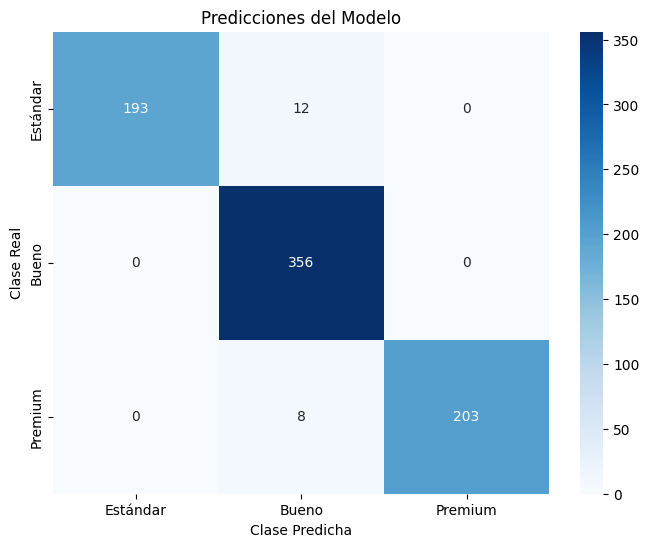

In [7]:
confusion = metrics.confusion_matrix(pred, ytest)
calidad = ['Estándar', 'Bueno', 'Premium']
plt.figure(figsize=(8,6))
sns.heatmap(confusion, annot=True, cmap='Blues', fmt='d', xticklabels= calidad, yticklabels= calidad)
plt.title('Predicciones del Modelo')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real');